<h1>MNIST Done Wrong</h1>
<p>The standard approach with MNIST to train a digit classifier using one or more (or some combination) of the following approaches: 
<ul>
<li>Logistic Regression</li>
<li>Support Vector Machine</li>
<li>Random Forest</li>
<li>Neural Network</li>
</ul>
Once we have trained a few different models, we start fine-tuning things by adjusting hyperparameters and adding regularization. This is a great approach, but it's not very fun if you are already familiar with MNIST.

Rather than do the reasonable thing, we are going to generate new sets of MNIST(ish) images, first using a recurrent neural network (RNN) that will produce a sequence of pixels from some initial state, and second a generative adversarial network (GAN) that will produce a sequence of pixels from some random noise. We will then train a classifier on these new datasets and see how well it performs on the original MNIST dataset.</p>

In [1]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import numpy as np

2023-06-19 19:12:24.484600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/handsonmachinelearning/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the MNIST dataset from keras
mnist = keras.datasets.mnist

# Seperate the dataset into training and testing data. Note that the labels are not needed for this project.
(x_train, _), (x_test, _) = mnist.load_data()

<h3>Remember MNIST?</h3>
<p>In the unlikely event that you don't remember MNIST, it is a dataset of handwritten digits that is commonly used to train and test machine learning models. It is a great dataset because it is small enough to train models quickly, but large enough to be non-trivial. It is also a great dataset because it is easy to visualize the data and the results of the model.</p>

<p>For example, here are the first 100 digits in the MNIST dataset:</p>

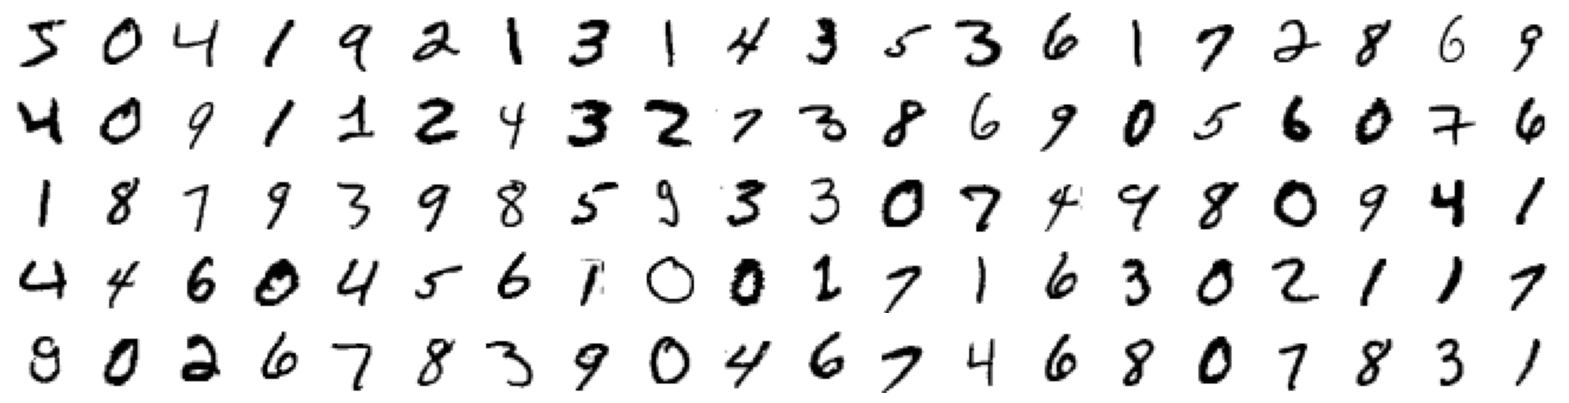

In [3]:
# The first 100 images in the training set in a 5x20 grid
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(x_train[i], cmap="binary")
    plt.axis('off') # Remove the axis
plt.show()


<p>Each of these images is 28x28 pixels, and each pixel is a value between 0 and 255. That means we can think of each image as a sequence of $28 \cdot 28 = 784$ values. We are going start by breaking images into subquences onsisting of the first and second half of each sequence. These will serve as the input sequences and target sequences for our RNN.</p>

In [4]:
# For each image, flatten the 28x28 array into a 784 array, cut it in half. We will use the first half of the sequence
# as an input and the second half as the target.

def flatten_and_sequencify(array) -> list:
    """
    Takes a 2D array of 28x28 pixels, flattens it, and breaks it into pairs of sequences, the first
    392 pixels, and the second 392 pixels. The former will be used as the input, and the latter will be used as the target.

    Args:
        array (list[list[float]]): A 2D array of 28x28 pixels

    Returns:
        list[list[float]]: A list of pairs of sequences, the first 392 pixels, and the second 392 pixels.
    
    Raises:
        ValueError: If the array is not 28x28

    """

    # Import numpy
    import numpy as np

    # Check if the array is 28x28
    if array.shape != (28,28):
        raise ValueError("Array is not 28x28")
    
    # Flatten the array
    flattened = array.flatten()

    # Return the first half of the array and the entire array
    return [flattened[:392], flattened[392:]]

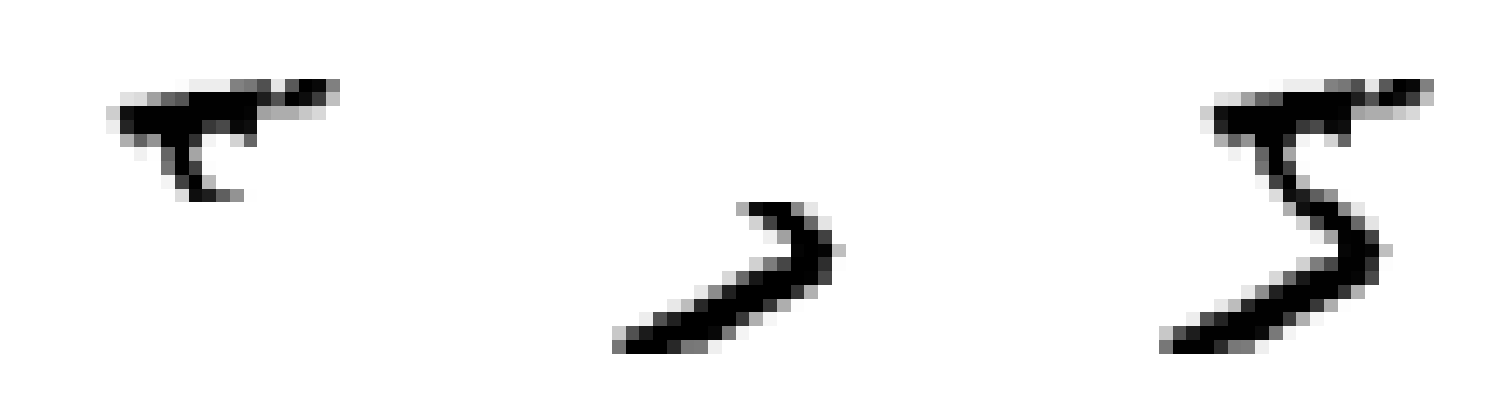

In [5]:
# Let's test the function on the first image in the training set and plot the results
first_image = x_train[0]
first_image_input, first_image_target = flatten_and_sequencify(first_image)

# Let's pad first_image_input with 0s to make it the same length as first_image_target
first_image_input = np.pad(first_image_input, (0, 392), 'constant')

# Now we need to front-pad the target with 0s to make it the same length as the input
first_image_target = np.pad(first_image_target, (392, 0), 'constant')

# Plot the input, target, and the original image
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(first_image_input.reshape(28,28), cmap="binary")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(first_image_target.reshape(28,28), cmap="binary")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(first_image, cmap="binary")
plt.axis('off')
plt.show()

This looks to be functioning according to plan. So let's create our real training set by generating a bunch of sequences of pixels from the MNIST dataset.

In [6]:
# Now, let's do this for all the images in the training set
X_train = []
y_train = []

for image in x_train:
    sequences = flatten_and_sequencify(image)
    X_train.append(sequences[0])
    y_train.append(sequences[1])

# Now, let's do this for all the images in the testing set
X_test = []
y_test = []

for image in x_test:
    sequences = flatten_and_sequencify(image)
    X_test.append(sequences[0])
    y_test.append(sequences[1])

In [7]:
# How many images are in the training set?
print("There are " + str(len(X_train)) + " images in the training set.")

There are 60000 images in the training set.


We now have 60,000 input sequences and 60,000 target sequences to work with for training and validation! Let's see how well we can train a model to predict the next pixel in the sequence. 

In [8]:
# Let's resplit the training set into a training set and a validation set where the validation set is 10% of the training set
X_val = X_train[:6000]
y_val = y_train[:6000]
X_train = X_train[6000:]
y_train = y_train[6000:]

# Let's also convert these lists to a format that tensorflow can understand
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)


In [9]:
def front_pad(image: list, length: int = 392) -> list:
    """
    Takes the last 392 pixels of an image and pads it in front with 0s to make it convertable to a 28x28 array

    Args:
        image (list[float]): A list of 392 pixels
        length (int, optional): The length of the array. Defaults to 392.

    Returns:
        list[float]: A list of 784 pixels
    
    Raises:
        ValueError: If the image is not 392 pixels long
    
    """

    # Check if the image is 392 pixels long
    if len(image) != 392:
        raise ValueError("Image is not 392 pixels long")
    
    # Pad the image with 0s
    padded_image = np.pad(image, (length, 0), 'constant')

    # Return the padded image
    return padded_image

def back_pad(image: list, length: int = 392) -> list:
    """
    Takes the first 392 pixels of an image and pads it in back with 0s to make it convertable to a 28x28 array

    Args:
        image (list[float]): A list of 392 pixels
        length (int, optional): The length of the array. Defaults to 392.

    Returns:
        list[float]: A list of 784 pixels
    
    Raises:
        ValueError: If the image is not 392 pixels long
    
    """

    # Check if the image is 392 pixels long
    if len(image) != 392:
        raise ValueError("Image is not 392 pixels long")
    
    # Pad the image with 0s
    padded_image = np.pad(image, (0, length), 'constant')

    # Return the padded image
    return padded_image

<h3>Let's see what we need to beat...</h3>
<p>Before we start developing a model, let's take a look at what we need to beat (at the very, VERY least). The simplest prediction that could be made is, of course, that the next pixel in a sequence is the same as the previous pixel, and then we repeat that for the rest of the missing pixels. Let's see how well that works.</p>

In [10]:
# Our fake predictions here will just be the last pixel in the input sequence repeated 392 times
y_pred = np.zeros((10000, 392))
for i in range(10000):
    y_pred[i] = np.array([X_test[i][-1]]*392)

# Let's find the MSE of our fake predictions
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("The MSE of our fake predictions is " + str(mse))

The MSE of our fake predictions is 7894.28274234694


<h2>Time to Train a Model!</h2>

<p>The time has come to see if we just wasted... our time!</p>

In [11]:
# Our model will need to be able take 392 pixels as input and output the next 392 pixels, so we will
# need to use in input shape of [None, 392, 1] and an output shape of [None, 392, 1]
# Both the input and output layers will be GRU layers with 392 units. We will also use
# two hidden layers with 128 nodes each. We will dropout 20% of the nodes in the hidden
# layers as a precaution against overfitting. We will use the Adam optimizer and the
# mean squared error loss function.

new_new_model = keras.models.Sequential([
    keras.layers.LSTM(392, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(392, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="relu"),
])

new_new_model.compile(loss="mse", optimizer="adam")

2023-06-19 19:12:46.022082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Reshape the expected output data
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [13]:
# Let's train the model for 3 epochs
picture_predictor = new_model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
1688/1688 [==============================] - 2544s 2s/step - loss: 5558.3540 - val_loss: 5132.8657
Epoch 2/3
1688/1688 [==============================] - 2488s 1s/step - loss: 5186.9717 - val_loss: 5140.9224
Epoch 3/3
1688/1688 [==============================] - 2482s 1s/step - loss: 5068.9932 - val_loss: 4981.7075


In [28]:
# We also need a function to convert the sequence back to a 28x28 array, so we need to multiply
# each of the values in the sequence by 255 and then reshape it to be a 28x28 array

def convert_sequence_to_array(sequence: list[float]) -> np.ndarray:
    """
    Takes a list of floats and converts it to a 28x28 array

    Args:
        sequence (list[float]): The sequence to convert

    Returns:
        np.ndarray: The 28x28 array

    Raises:
        ValueError: If the length of the sequence is not 784
    """

    # Check if the length of the sequence is not 784
    if len(sequence) != 784:
        raise ValueError("The length of the sequence must be 784")

    # Convert the sequence to an array
    array = np.array(sequence)
    # Multiply each value by 255
    array *= 255
    # Reshape the array to be a 28x28 array
    array = array.reshape(28, 28)

    return array

1/1 [==============================] - 0s 71ms/step
(392,)
(392,)


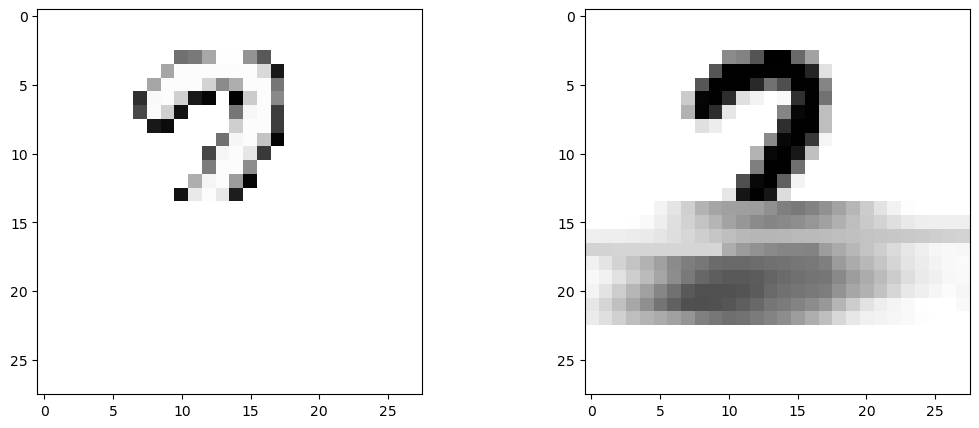

In [55]:
# Let's try to create a picture from the first image in the test set
first_image = X_test[1]
first_image = np.expand_dims(first_image, axis=0)
first_image = np.expand_dims(first_image, axis=-1)

# Let's predict the next 392 pixels
first_image_pred = new_model.predict(first_image)

print(X_test[1].shape)
print(first_image_pred[0][110].shape)

# Let's plot the input, target, and prediction
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)

# Plot the input, after padding it and converting it to an array
plt.imshow(convert_sequence_to_array(back_pad(X_test[1])), cmap="binary")


# Find the means of all 392 predictions
means = np.mean(first_image_pred[0], axis=1)

# Convert the means to an array that can be plotted
means = np.array(means)

# Combine the input and the means
combined = np.concatenate((X_test[1], means))

# Plot the combined input and means
plt.subplot(1,3,2)
plt.imshow(convert_sequence_to_array(combined), cmap="binary")

plt.show()



1/1 [==============================] - 0s 67ms/step


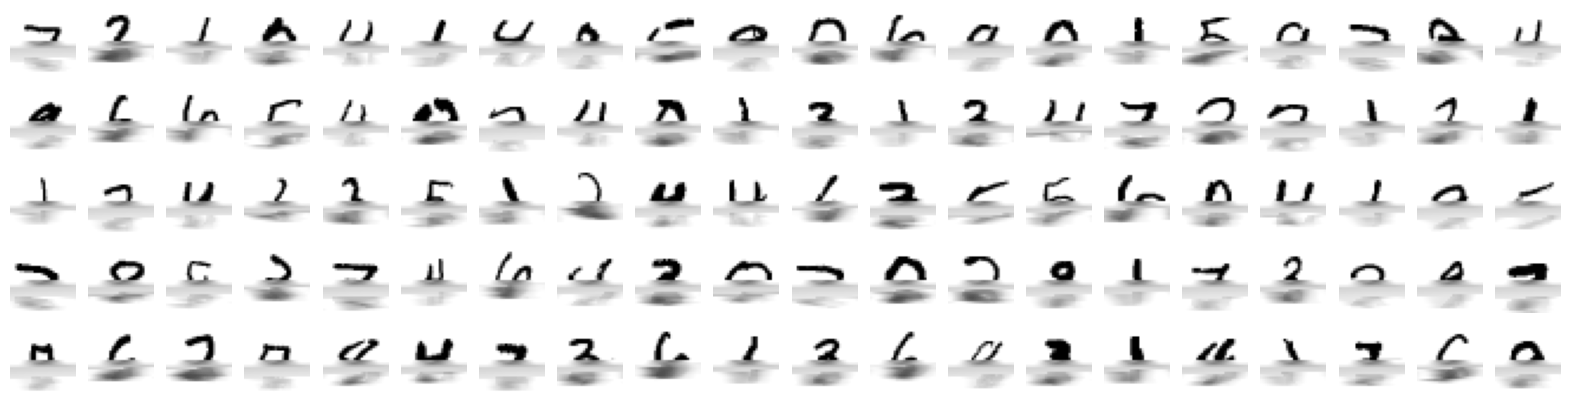

In [59]:
# Let's repeat the process for the first 100 images in the test set, and plot the results in a 5x20 grid
fig = plt.figure(figsize=(20, 5))
for i in range(100):
    # Get the image
    image = X_test[i]
    # Expand the dimensions of the image
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    # Predict the next 392 pixels
    image_pred = new_model.predict(image)
    # Find the means of all 392 predictions
    means = np.mean(image_pred[0], axis=1)
    # Convert the means to an array that can be plotted
    means = np.array(means)
    # Combine the input and the means
    combined = np.concatenate((X_test[i], means))
   
    # Plot the input, target, and prediction
    plt.subplot(5, 20, i+1)
    plt.imshow(convert_sequence_to_array(combined), cmap="binary")
    plt.axis("off")

plt.show()